In [1]:
!pip install -q kaggle

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download -d ambarish/breakhis
!unzip -q breakhis.zip -d /content/breakhis

Dataset URL: https://www.kaggle.com/datasets/ambarish/breakhis
License(s): unknown
 98% 3.90G/3.99G [01:12<00:03, 23.6MB/s]
100% 3.99G/3.99G [01:12<00:00, 59.2MB/s]


In [3]:
import os
import random
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import save_image

In [4]:
class ImageAugmentation:
    def __init__(self):
        self.augmentations = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(30),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0))
        ])

    def augment(self, image):
        return self.augmentations(image)

In [5]:
data_dir = '/content/breakhis/BreaKHis_v1'

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [6]:
def get_data_loaders(data_dir, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
    val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

def train_transfer_learning(data_dir, num_classes=2, epochs=10, lr=1e-3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    train_loader, val_loader = get_data_loaders(data_dir)

    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / total
        epoch_acc = correct / total

        print(f'Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.4f}')

def evaluate_model(model, dataloader):
    model.eval()
    device = next(model.parameters()).device

    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = correct / total
    print(f'Validation Accuracy: {accuracy:.4f}')

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def train_simple_cnn(data_dir, num_classes=2, epochs=10, batch_size=32, lr=1e-3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
    val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = SimpleCNN(num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / total
        epoch_acc = correct / total

        print(f'Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.4f}')

In [8]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, img_shape=(3, 64, 64)):
        super(Generator, self).__init__()
        self.img_shape = img_shape
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img

class Discriminator(nn.Module):
    def __init__(self, img_shape=(3, 64, 64)):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

In [9]:
class DCGANGenerator(nn.Module):
    def __init__(self, latent_dim=100):
        super(DCGANGenerator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.model(input)

class DCGANDiscriminator(nn.Module):
    def __init__(self):
        super(DCGANDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.model(input).view(-1, 1)

def train_dcgan(data_loader, latent_dim=100, epochs=20, lr=0.0002):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    netG = DCGANGenerator(latent_dim).to(device)
    netD = DCGANDiscriminator().to(device)

    criterion = nn.BCELoss()
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for i, (imgs, _) in enumerate(data_loader):
            batch_size = imgs.size(0)
            real_labels = torch.ones(batch_size, 1, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)

            imgs = imgs.to(device)

            optimizerD.zero_grad()
            outputs = netD(imgs)
            d_loss_real = criterion(outputs, real_labels)
            d_loss_real.backward()

            noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            fake_imgs = netG(noise)

            outputs = netD(fake_imgs.detach())
            d_loss_fake = criterion(outputs, fake_labels)
            d_loss_fake.backward()

            optimizerD.step()

            optimizerG.zero_grad()
            outputs = netD(fake_imgs)
            g_loss = criterion(outputs, real_labels)
            g_loss.backward()
            optimizerG.step()

            if i % 50 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Step [{i}/{len(data_loader)}], '
                      f'D Loss: {d_loss_real.item() + d_loss_fake.item():.4f}, G Loss: {g_loss.item():.4f}')
        if (epoch + 1) % 5 == 0:
            save_image(fake_imgs.data[:25], f'output_epoch_{epoch+1}.png', nrow=5, normalize=True)

    return netG, netD

In [10]:
netG, netD = train_dcgan(data_loader, epochs=20)

Epoch [1/20], Step [0/124], D Loss: 1.4159, G Loss: 3.1293
Epoch [1/20], Step [50/124], D Loss: 0.0013, G Loss: 13.0438
Epoch [1/20], Step [100/124], D Loss: 0.0039, G Loss: 19.2987
Epoch [2/20], Step [0/124], D Loss: 0.0585, G Loss: 16.4353
Epoch [2/20], Step [50/124], D Loss: 0.2079, G Loss: 4.8143
Epoch [2/20], Step [100/124], D Loss: 0.2989, G Loss: 6.1150
Epoch [3/20], Step [0/124], D Loss: 0.5511, G Loss: 6.4095
Epoch [3/20], Step [50/124], D Loss: 0.2324, G Loss: 3.8677
Epoch [3/20], Step [100/124], D Loss: 0.2175, G Loss: 2.6450
Epoch [4/20], Step [0/124], D Loss: 0.5225, G Loss: 2.6983
Epoch [4/20], Step [50/124], D Loss: 0.5813, G Loss: 3.5472
Epoch [4/20], Step [100/124], D Loss: 0.3346, G Loss: 4.1843
Epoch [5/20], Step [0/124], D Loss: 0.7540, G Loss: 3.7316
Epoch [5/20], Step [50/124], D Loss: 0.9018, G Loss: 2.1684
Epoch [5/20], Step [100/124], D Loss: 0.6905, G Loss: 3.9766
Epoch [6/20], Step [0/124], D Loss: 0.7517, G Loss: 5.1636
Epoch [6/20], Step [50/124], D Loss: 0

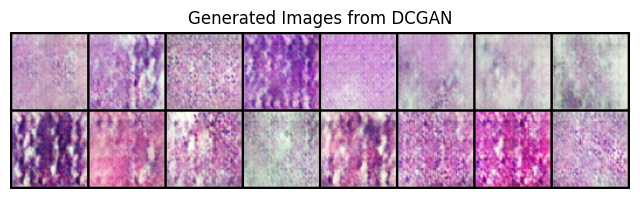

In [11]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

netG.eval()

latent_dim = 100
num_images = 16
z = torch.randn(num_images, latent_dim, 1, 1).to(next(netG.parameters()).device)

with torch.no_grad():
    fake_images = netG(z).detach().cpu()

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Generated Images from DCGAN")
plt.imshow(np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True), (1,2,0)))
plt.show()

vutils.save_image(fake_images, "generated_samples.png", normalize=True)


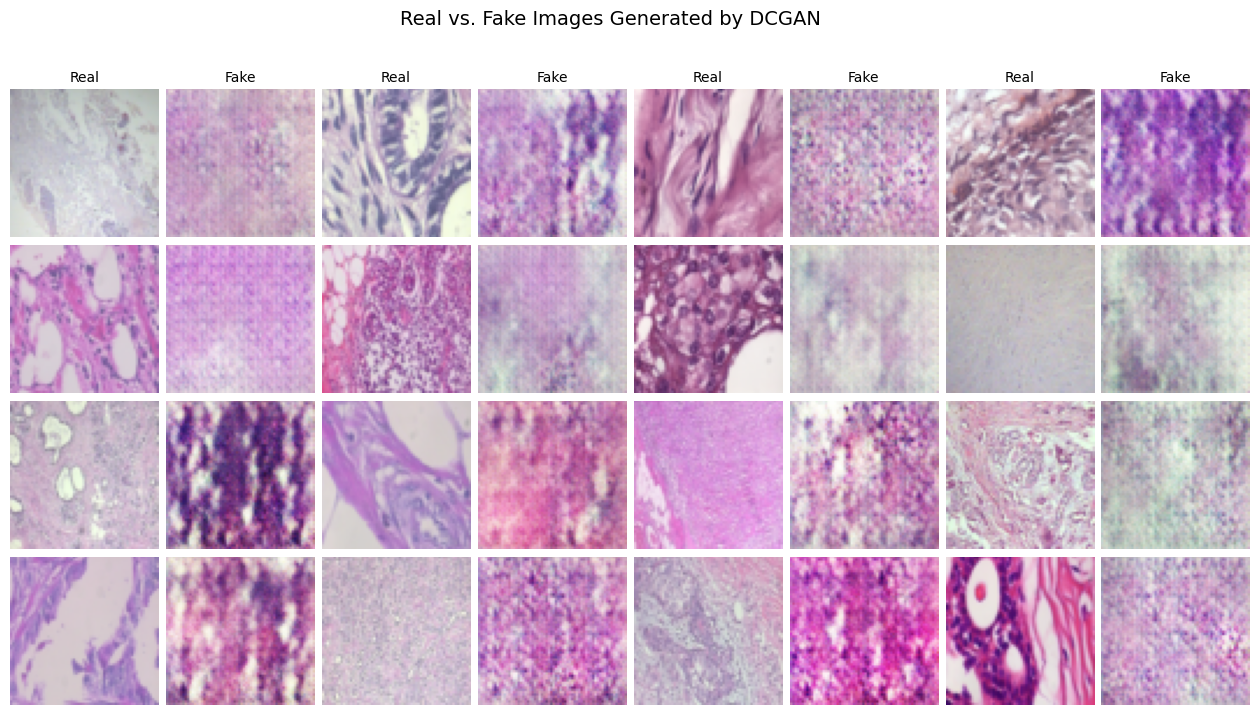

In [12]:
import itertools

real_batch = next(iter(data_loader))

real_images = real_batch[0][:16]
fake_images = fake_images[:16]
def denorm(img_tensor):
    return img_tensor * 0.5 + 0.5

real_images = denorm(real_images)
fake_images = denorm(fake_images)
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for i, (real, fake) in enumerate(itertools.islice(zip(real_images, fake_images), 16)):
    ax = axes[i // 4, (i % 4) * 2]
    ax.imshow(np.transpose(real.numpy(), (1, 2, 0)))
    ax.axis("off")
    if i // 4 == 0:
        ax.set_title("Real", fontsize=10)
    ax = axes[i // 4, (i % 4) * 2 + 1]
    ax.imshow(np.transpose(fake.numpy(), (1, 2, 0)))
    ax.axis("off")
    if i // 4 == 0:
        ax.set_title("Fake", fontsize=10)

plt.suptitle("Real vs. Fake Images Generated by DCGAN", fontsize=14)
plt.show()
